# Pattern Compare

Aims to answer the question **Are there any key similarities or differences between malicious and benign samples in terms of API Call Patterns?** in **4.2.6. Dataset Analysis** of the study.

Note that this notebook only makes use of the verified xxxx_SampleHash_Common.csv file which represents a significant majority of the entire Oliveira dataset.  

## Import Libraries/Datasets

In [1]:
import pandas as pd
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import time

malicious_df = pd.read_csv('./(EDITED)KMeans_SampleHash_Common.csv', low_memory=False) #This should point to a verified <DataClustering>_SampleHash_Common.csv file
benign_df = pd.read_csv('./API_Patterns.csv') #This should point to the API_Patterns.csv file

#Load list of API calls
API_LIST = "../api_calls.txt"
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split
# APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

## DataFrame Preview

In [2]:
malicious_df.replace(to_replace='-',value='_', inplace=True)
malicious_df

,cluster,hash,Type 1,Type 2,Type 3,pattern
0,0,490d584c7d303ed35c673460b63f3ca8,trojan,dropper,pua,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
1,0,9ab8ea1d2d68a0d4110df413e677976c,trojan,hacktool,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
2,0,adbc74815ef2bd1ea4967abad812233d,trojan,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
3,0,f6eb4841bba3a4cee747700dc0ee1609,_,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
4,0,f5a0ad49337ebc87897698e70d03364e,trojan,dropper,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
...,...,...,...,...,...,...
1756,198,d24b78bd73f17379ed62e4c776b4f66e,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1757,198,f666dd4b3a53b7fe71f8976fa09bfdfb,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1758,199,b6d6520b608875282d831b1e983cd5e5,_,_,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1759,199,18bce1a594550daf8b3f318de48c1674,trojan,dropper,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."


In [3]:
#Drop row that is falsely labelled.
malicious_df.drop(malicious_df[(malicious_df['Type 1']=='_')].index, inplace=True)
malicious_df

,cluster,hash,Type 1,Type 2,Type 3,pattern
0,0,490d584c7d303ed35c673460b63f3ca8,trojan,dropper,pua,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
1,0,9ab8ea1d2d68a0d4110df413e677976c,trojan,hacktool,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
2,0,adbc74815ef2bd1ea4967abad812233d,trojan,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
4,0,f5a0ad49337ebc87897698e70d03364e,trojan,dropper,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
5,0,4c972b447659f1e86769eb43593fd2a5,trojan,downloader,dropper,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
...,...,...,...,...,...,...
1755,198,0226e311ed2648ff399c7902fc113421,adware,trojan,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1756,198,d24b78bd73f17379ed62e4c776b4f66e,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1757,198,f666dd4b3a53b7fe71f8976fa09bfdfb,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1759,199,18bce1a594550daf8b3f318de48c1674,trojan,dropper,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."


In [4]:
benign_df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,pattern
0,5b51d65972a349f90a86984c26b12b30,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,CoCreateInstance,NtOpenSection,CreateDirectoryW,NtCreateFile,LdrGetProcedureAddress,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1,ceb8cc125478fad641daa4e04e9b2f19,GetSystemInfo,NtAllocateVirtualMemory,NtOpenSection,GetTempPathW,CreateDirectoryW,GetFileAttributesW,FindFirstFileExW,DeleteFileW,NtQueryDirectoryFile,...,NtClose,NtCreateMutant,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,NtClose,NtCreateMutant,NtClose,NtCreateFile,"GetSystemInfo,NtAllocateVirtualMemory,NtOpenSe..."
2,f108600edf46d7c20f6acc522aeba6df,GetSystemTimeAsFileTime,NtProtectVirtualMemory,SetUnhandledExceptionFilter,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,...,SetErrorMode,GetFileAttributesExW,SetErrorMode,NtAllocateVirtualMemory,SetErrorMode,GetFileAttributesExW,SetErrorMode,FindFirstFileExW,NtQueryDirectoryFile,"GetSystemTimeAsFileTime,NtProtectVirtualMemory..."
3,711be6337cb78a948f04759a0bd210ce,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetProcedureAddress,GetSystemMetrics,LdrLoadDll,LdrGetProcedureAddress,GetSystemMetrics,NtAllocateVirtualMemory,LdrLoadDll,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
4,6de26f67ceb1e3303b889489010f4c3f,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,LoadStringW,GetSystemWindowsDirectoryW,GetSystemDirectoryW,RegOpenKeyExW,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,d282ef96a93986f89825508812958354,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1075,c0389d256f976044adf570f0df908953,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetCursorPos,SetErrorMode,FindResourceW,SetWindowsHookExW,CoInitializeEx,NtDuplicateObject,NtAllocateVirtualMemory,...,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,GetSystemMetrics,RegOpenKeyExW,NtAllocateVirtualMemory,GetSystemMetrics,NtAllocateVirtualMemory,"GetSystemTimeAsFileTime,SetUnhandledExceptionF..."
1076,20316e717de5db169aecbb67377504ce,SetUnhandledExceptionFilter,NtCreateMutant,NtAllocateVirtualMemory,NtClose,NtCreateMutant,NtClose,NtCreateMutant,NtClose,NtAllocateVirtualMemory,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,"SetUnhandledExceptionFilter,NtCreateMutant,NtA..."
1077,ce945d424b93ea73fbbedf0254f6bc07,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,FindResourceExW,LoadResource,"NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOp..."


## Identify Malware Types

Same as the output of `1 MalwareTypes_in_Dataset.txt`

In [5]:
'''Identify popular malware types in the dataset per Type as validated by VirusTotal.'''

def identify(malware_type:str):
    '''Identify and count the malware types per type'''
    print(f"{malware_type.upper()} LABEL")
    unique = list(malicious_df[malware_type].unique())
    if '_' in unique:
        unique.remove('_')
    quantities = []
    for t in unique:
        quantities.append([t, len(malicious_df[malicious_df[malware_type]==t])])
    quantities.sort(key=lambda ls: ls[1], reverse=True)
    for q in quantities:
        print(f"{q[0]:12s}: {q[1]}")
    print("")
    
'''Executes the identification for each type'''
types = ['Type 1']
for i in types:    
    identify(i)

TYPE 1 LABEL
trojan      : 1340
adware      : 195
downloader  : 78
ransomware  : 19
miner       : 14
dropper     : 4
pua         : 3
virus       : 1
hacktool    : 1



## Extract API Patterns

In [6]:
malicious_patterns = malicious_df['pattern'].to_list()
print("Malicious Sample API Patterns: ", len(malicious_patterns))
#display(malicious_patterns)

benign_patterns = benign_df['pattern'].to_list()
print("Benign Sample API Patterns: ", len(benign_patterns))
#display(benign_patterns)

Malicious Sample API Patterns:  1655
Benign Sample API Patterns:  1079


## Compare API Call Patterns

**Note that this uses the full API Call Patterns (i.e., Time-based Behaviors)**

Find those most similar unique malicious API call patterns that match those unique benign API call patterns.

In [7]:
#This code block may take a while to complete. SequenceMatcher.ratio() is deemed slow even by its documentation.
print("Comparing API Call Patterns...")
ratio = 0
ratios = []
start = time.time()

unique_malicious = list(malicious_df['pattern'].unique())
unique_benign = list(benign_df['pattern'].unique())
print(f"No. of unique malicious patterns: {len(unique_malicious)}")
print(f"No. of unique benign patterns: {len(unique_benign)}")
print("")
for m,ma in enumerate(unique_malicious): #For efficiency's sake, let's just compare it to unique malicious samples. Hashes that match the same malicious pattern will be collected in batches instead of one by one.
    mal_df = malicious_df[malicious_df['pattern']== ma]
    st = time.time()
    for b,be in enumerate(unique_benign): #For efficiency's sake, let's just compare it to unique benign samples. Hashes that match the same benign pattern will be collected in batches instead of one by one.
        ratios.append({'ratio': SequenceMatcher(None, ma, be).ratio(), #<=== SequenceMatcher is slow BTW.
                       'benign_pattern':be, 'malicious_pattern': ma,
                       'Type 1':mal_df['Type 1'].to_list(), 
                    #    'Type 2':mal_df['Type 2'].to_list(), 
                    #    'Type 3':mal_df['Type 3'].to_list(), 
                       'malicious_hash':mal_df['hash'].to_list(), 
                       'benign_hash':benign_df[benign_df['pattern'] == be]['hash'].to_list()})
    print(f"Unique Mal. Pattern {m} {ma[0:30]}... @ {time.time()-st:.4f}s")
elapsed = time.time()-start

Comparing API Call Patterns...
No. of unique malicious patterns: 199
No. of unique benign patterns: 624

Unique Mal. Pattern 0 GetSystemTimeAsFileTime,NtCrea... @ 6.2165s
Unique Mal. Pattern 1 LdrGetDllHandle,LdrGetProcedur... @ 8.4727s
Unique Mal. Pattern 2 GetSystemTimeAsFileTime,LdrLoa... @ 5.6899s
Unique Mal. Pattern 3 SetErrorMode,OleInitialize,Ldr... @ 5.0072s
Unique Mal. Pattern 4 GetSystemTimeAsFileTime,GetSys... @ 5.8715s
Unique Mal. Pattern 5 RegOpenKeyExA,NtOpenKey,NtQuer... @ 4.6577s
Unique Mal. Pattern 6 GetSystemTimeAsFileTime,NtAllo... @ 5.4548s
Unique Mal. Pattern 7 LdrLoadDll,LdrGetProcedureAddr... @ 4.6147s
Unique Mal. Pattern 8 GetSystemTimeAsFileTime,LdrLoa... @ 5.7411s
Unique Mal. Pattern 9 LdrLoadDll,LdrGetProcedureAddr... @ 4.7325s
Unique Mal. Pattern 10 NtClose,NtOpenKey,NtQueryValue... @ 4.9955s
Unique Mal. Pattern 11 GetSystemTimeAsFileTime,LdrLoa... @ 6.0634s
Unique Mal. Pattern 12 NtClose,NtOpenKey,NtQueryValue... @ 5.1886s
Unique Mal. Pattern 13 NtAllocateV

In [8]:
str_output = ""
size = len(benign_patterns) * len(malicious_patterns)
for r in ratios:
    ratio += r['ratio']
ratio /= size
ratios.sort(reverse=True,key=lambda ratio: ratio['ratio'])
str_output += f"Average Similarity Ratio: {ratio*100:.4f}%\n"
str_output += f"Time Elapsed: {elapsed:0.4f}s\n"
str_output += f"Time per Sample: {elapsed/size:0.4f}s\n"

with open("./Output/3 Similarity Ratio.txt", 'w') as f:
    f.write(str_output)
    f.flush()
    f.close()

### Distribution of Similarity Ratios

The graph that the code block below produces indicates the most common similarity ratio between malicious and benign samples in terms of unique API calls.

Being bias on the left means that most malicious API Call Patterns are different to that found in benign API Call Patterns (but that does not mean that there are no same ones that exist).

Being bias on the right means that most malicious API Call Patterns are the same to that found in benign API Call Patterns (but that does not mean that there are no different ones that exist).

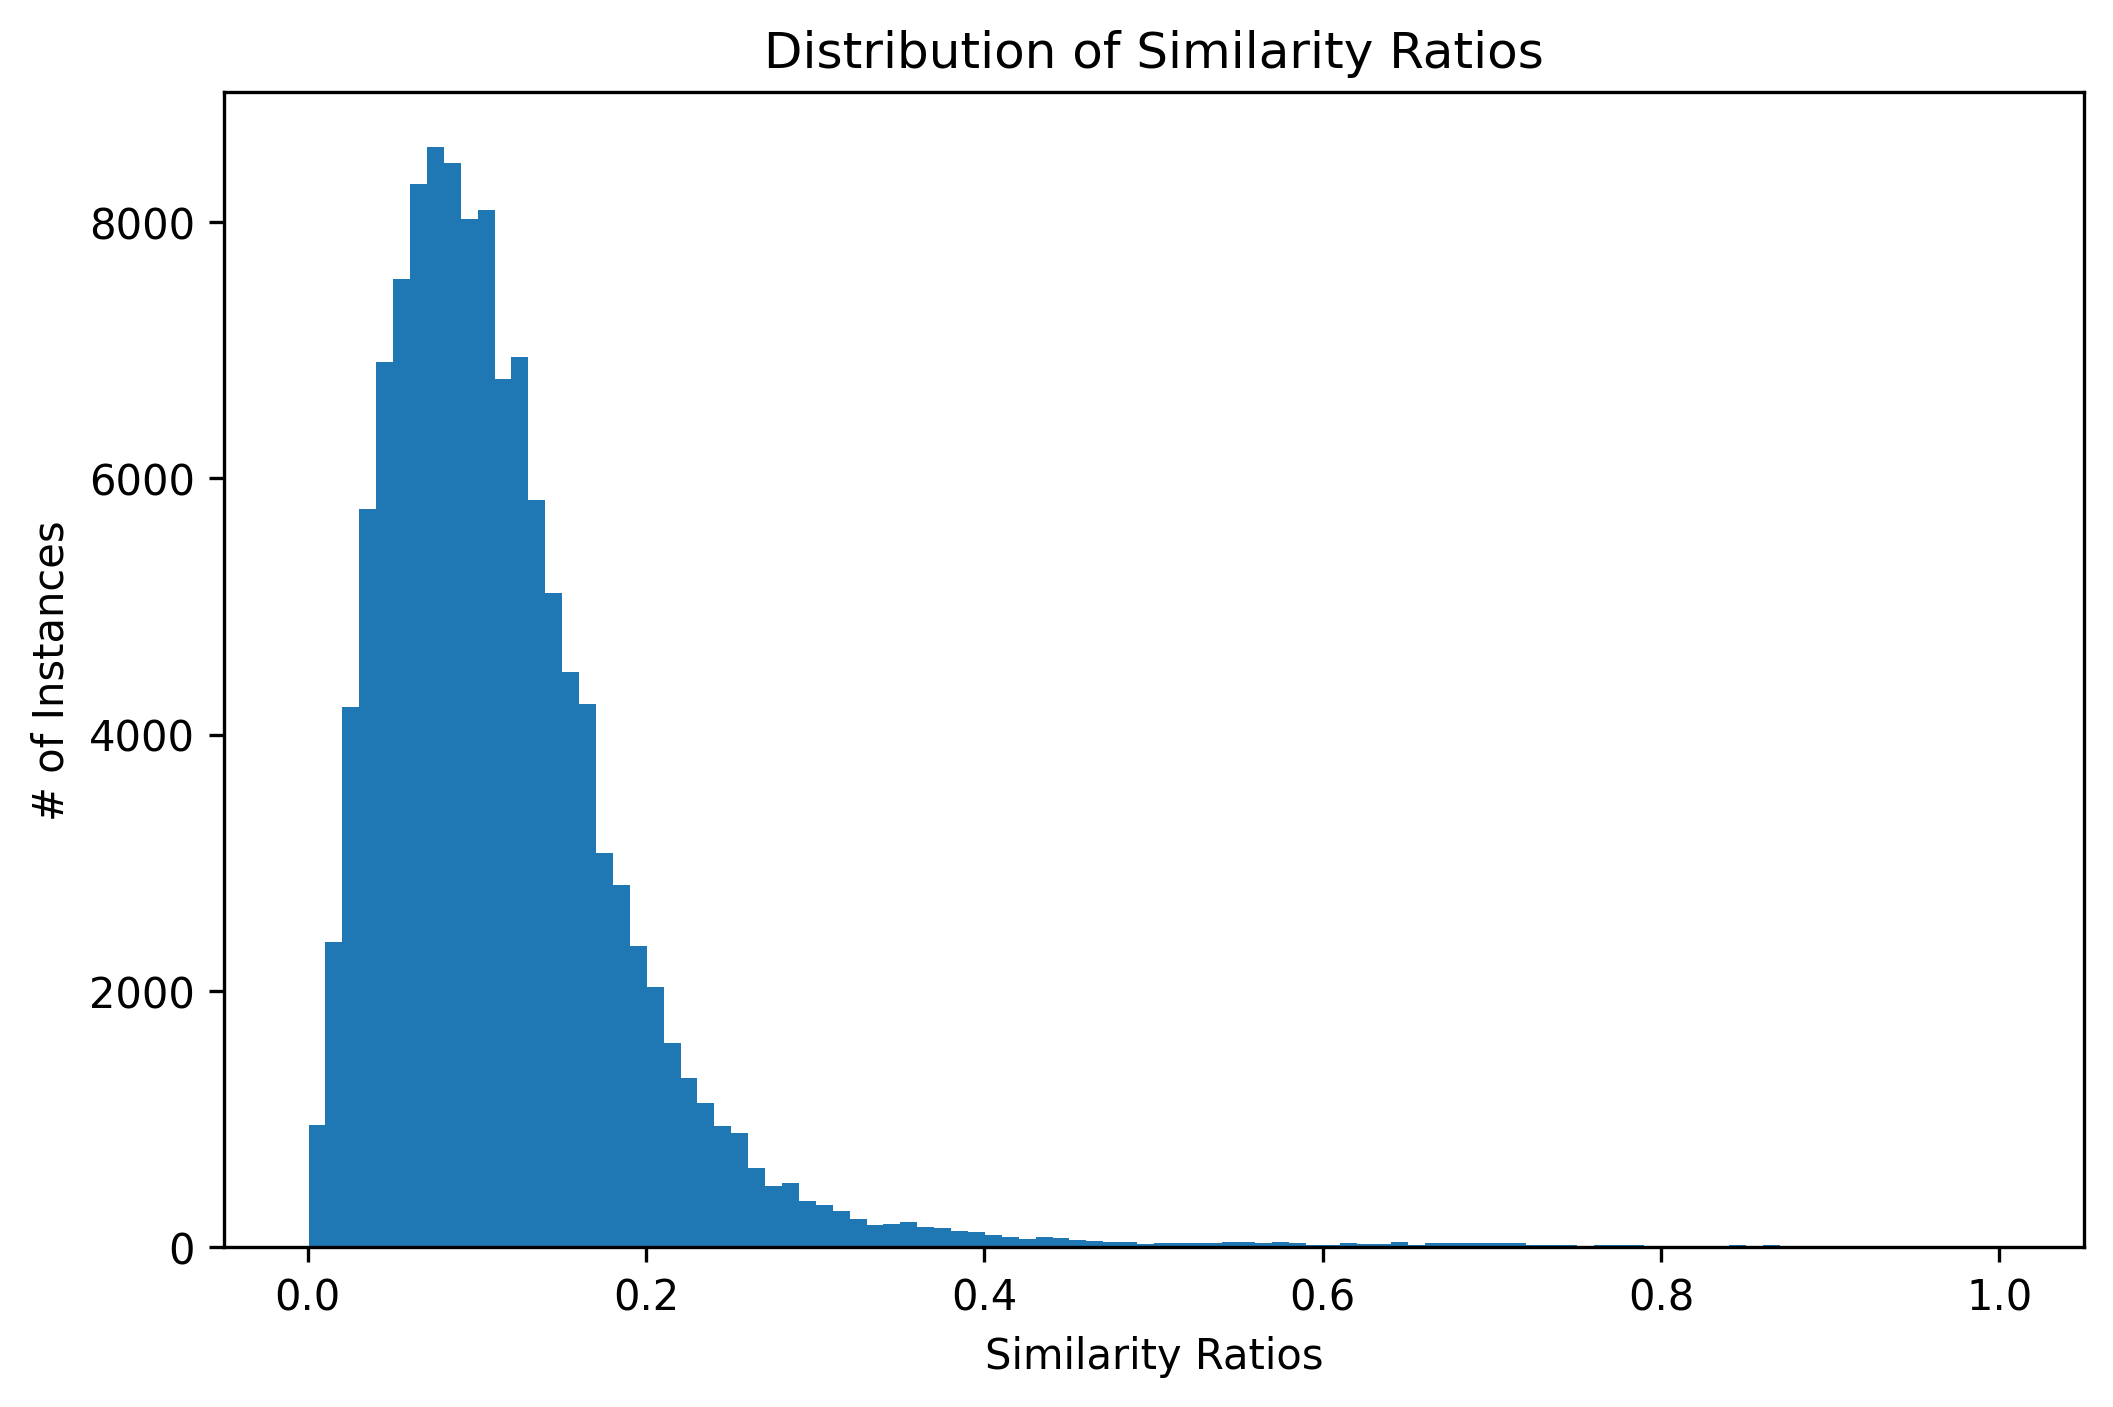

In [9]:
ratio_only = []
for r in ratios:
    ratio_only.append(r['ratio'])
plt.figure(figsize=(8,5), dpi=300)
plt.title('Distribution of Similarity Ratios')
plt.xlabel('Similarity Ratios')
plt.ylabel('# of Instances')
n, bins, patches = plt.hist(ratio_only, bins=100, orientation='vertical')
plt.savefig("./Output/3 Distribution_Similarity_Ratio.png")
plt.show()

In [13]:
def print_comparison(types:str, ratios:list, max:int):
    if max > len(ratios):
        print(f"The specified `max` value ({max}) exceeds the number available ratios to select.")
        max = len(ratios)
    states = []
    output = ""
    for r in range(0,max):
        output += f"MATCH {r+1}\n"
        output += f"Malicious Hashes ({len(ratios[r]['malicious_hash'])}):\n"
        for t in range(len(ratios[r]['malicious_hash'])): # All malicious hashes that have the same API Call
            output += f"\t{ratios[r]['malicious_hash'][t]} - {ratios[r]['Type 1'][t]}" + "\n"
        output += f"Benign Hashes ({len(ratios[r]['benign_hash'])}):\n"
        for b in range(len(ratios[r]['benign_hash'])): # All benign hashes that have the same API Call Pattern
            output += f"\t{ratios[r]['benign_hash'][b]}\n"
        output += f"Score: {ratios[r]['ratio']:.4f}\n" # Similarity Ratio
        output += f"Malicious API Call Pattern: {ratios[r]['malicious_pattern']}\n" # API Call Pattern (from Malicious)
        output += f"Benign API Call Pattern: {ratios[r]['benign_pattern']}\n" # API Call Pattern (from Benign)
        output += "\n"
        for t in range(len(ratios[r]['malicious_hash'])): # Malware Types of matching Malicious Samples
            states.append(ratios[r]['Type 1'][t]) 
        output += "====================================================================================\n"
    common_states = pd.Series(states).sort_values()
    output += "\n"
    output += f"Malware Types of the Top {max} Most Matching API Call Patterns to Benign Samples:\n"
    output += str(pd.Series(common_states).sort_values().value_counts()) + "\n"
    print(output, file=open(f"./Output/3 {types}.txt",'w'))
    print(output)

## High Matching Ratios

Samples with high matching ratio in terms of pattern (i.e., states) are ideally the following:
1. The malicious sample is a `trojan` hence must have similar behaviors as a benign software. It might be the limitation of the dataset having only the first 100 API calls and may not have included the rest.
2. The malicious sample is falsely labelled (i.e., `_ _ _`)as malicious (i.e., false-positive) which is supported by it matching the behavior of benign samples.

In [14]:
# MOST SIMILAR API CALL PATTERNS TO BOTH MALICIOUS AND BENIGN SAMPLES
top = 20 # Modify to Top n Most Similar/Different
ratios.sort(reverse=True,key=lambda ratio: ratio['ratio'])
print_comparison("HighMatching_Similar", ratios, top) 

MATCH 1
Malicious Hashes (9):
	490d584c7d303ed35c673460b63f3ca8 - trojan
	9ab8ea1d2d68a0d4110df413e677976c - trojan
	adbc74815ef2bd1ea4967abad812233d - trojan
	f5a0ad49337ebc87897698e70d03364e - trojan
	4c972b447659f1e86769eb43593fd2a5 - trojan
	f23ecef8b4f9618644532605576dc981 - trojan
	a173ee9b4b2d991c37af8180bf511867 - trojan
	233cd454304dc47b37830ce11a045eef - trojan
	fded249c870bd4014890c497ecc4e5b7 - trojan
Benign Hashes (2):
	1d5be1a1f06fb4af76db691286667685
	e17c7fc99e55278c9377e0ba686b4002
Score: 1.0000
Malicious API Call Pattern: GetSystemTimeAsFileTime,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKeyEx,NtQueryKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumKeyExW,RegOpenKeyExW,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumValueW,LdrGetProcedureAddress,RegCloseKey,GetFileAttributesW,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryValueExW,RegCloseKey,NtOpenFile,NtQueryDirectoryFile,NtClose,Reg

## Low Matching Ratios

Samples with low matching ratio in terms of pattern (i.e., states) are ideally the following:
1. The malicious sample is a `trojan` hence must have similar behaviors as a benign software. It might be the limitation of the dataset having only the first 100 API calls and may not have included the rest.
2. The malicious sample is falsely labelled as malicious (i.e., false-positive) which is supported by it matching the behavior of benign samples.

In [15]:
# MOST DIFFERENT API CALL PATTERNS TO BOTH MALICIOUS AND BENIGN SAMPLES
ratios.sort(reverse=False,key=lambda ratio: ratio['ratio'])
print_comparison("LowMatching_Different",ratios, top)

MATCH 1
Malicious Hashes (7):
	1901fc38186ae1bed1b5da4874cfa382 - trojan
	ee964197100d076072b6fdc5bfaf297b - trojan
	ead8622597de71be8384b3849c20216f - trojan
	1da9e321b4857c7ffc9e54a6449749c5 - trojan
	b523acc5da1636551efdbdbca0cbd213 - trojan
	ded641f741d8eda8be254e981d37c29c - trojan
	1feb2a391cd4f44a9400b9b85caa141f - trojan
Benign Hashes (2):
	5af545fe09a6680a1b4e1b3aaa2a8031
	fb4462fd7462e2e5dd100132ed7b38df
Score: 0.0005
Malicious API Call Pattern: NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInfor